<a href="https://colab.research.google.com/github/Zimo0528/Supply-Chain/blob/main/Supply_Chain_CaLNG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
# load libraries
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# control the figure size
plt.rcParams["figure.figsize"] = (20,3)


In [ ]:
# load demand data
demand_data = pd.read_csv(
    'https://raw.githubusercontent.com/nosadchiy/public/main/demand.csv',
    dtype={"Month": str, "Date": int, "Demand": int})

# load intake price data
intake_price_data =  pd.read_csv(
    'https://raw.githubusercontent.com/nosadchiy/public/main/intake_price.csv',
    dtype={"Intake": int, "Price": float})

In [ ]:
# inspect demand data
demand_data.head()

,Month,Date,Demand
0,December,1,94
1,December,2,304
2,December,3,70
3,December,4,222
4,December,5,123


In [ ]:
# inspect intake price data
intake_price_data.head()

,Intake,Price
0,20,1.0
1,24,1.0
2,31,1.0
3,34,1.0
4,37,1.0


# Decision Variables

In [ ]:
# decision variables
calng_price = 7.50 # set by CaLNG

peak_intake_from_pipeline = 181

# Utility (Actual Usage)

In [ ]:
def determine_actual_usage(demand_data, calng_price, peak_intake_from_pipeline, total_lng_intake):
    '''
    this function determines the actual usage given CaLNG's price and peak intake from pipeline

    inputs:
    - calng_price: price set by CaLNG
    - peak_intake_from_pipeline: maximum intake from pipeline, after which consume LNG
    - demand_data: observed demand data (Month, Data, Demand in MMcF)
    - total_lng_intake: maximum amount ogf LNG to be used over the season

    outputs:
    - usage_data: usage data given observed demand, CaLNG price, and peak intake from pipeline
    '''
    usage_data = demand_data.copy()

    # set price index
    usage_data.reset_index(inplace=True, drop=False)
    usage_data = usage_data.rename(columns={'index': 'price_index'})

    usage_data['pipeline_price'] = usage_data.apply(lambda row: math.exp(max(0, (row['Demand'] - 144)/60)), axis=1)
    usage_data['cost_from_pipeline_only'] = usage_data['Demand'] * usage_data['pipeline_price']
    usage_data['demand_for_lng'] = usage_data.apply(lambda row: max(row['Demand'] - peak_intake_from_pipeline, 0), axis=1)
    usage_data['purchase_from_calng'] = 0

    accumulated_lng_usage = 0

    for index, row in usage_data.iterrows():
        purchase =  min(row['demand_for_lng'], total_lng_intake - accumulated_lng_usage)
        usage_data.loc[index, 'purchase_from_calng'] = purchase
        accumulated_lng_usage = accumulated_lng_usage + purchase


    usage_data['pipeline_intake'] = usage_data['Demand']-usage_data['purchase_from_calng']
    usage_data['pipeline_intake_price'] = usage_data.apply(lambda row: math.exp(max(0, (row['pipeline_intake'] - 144)/60)), axis=1)
    usage_data['cost_from_both'] = usage_data['pipeline_intake'] * usage_data['pipeline_intake_price'] + usage_data['purchase_from_calng'] * calng_price
    usage_data['savings'] = usage_data['cost_from_pipeline_only'] - usage_data['cost_from_both']

    return usage_data


In [ ]:
def calculate_cost_statistics(usage_data, calng_price, peak_intake_from_pipeline, total_lng_purchase, return_data=False):
    cost_data = usage_data.copy()
    cost_data['pipeline_intake_cost'] = cost_data['pipeline_intake'] * cost_data['pipeline_intake_price']
    cost_data['calng_intake_cost'] = cost_data['purchase_from_calng'] * calng_price

    total_pipeline_intake = sum(cost_data['pipeline_intake'])
    total_calng_intake = sum(cost_data['purchase_from_calng'])

    total_pipeline_intake_cost = sum(cost_data['pipeline_intake_cost']) * 1000
    total_calng_intake_cost = total_lng_purchase*calng_price * 1000
    total_utility_cost = total_pipeline_intake_cost + total_calng_intake_cost
    total_savings = sum(cost_data['savings']) * 1000

    average_demand = np.mean(cost_data['Demand'])
    average_price = math.exp(max(0, (average_demand - 144)/60))

    total_average_draw_daily = sum(cost_data['Demand']) * average_price * 1000

    if not return_data:
        print(f"CaLNG price: ${calng_price:<04}")

        print("---")
        print(f"Peak intake from pipeline: {peak_intake_from_pipeline:,.0f} MMcf")
        print(f"Total peak months intake from pipeline: {total_pipeline_intake:,.0f} MMcf")
        print(f"Total intake from CaLNG: {total_calng_intake:,.0f} MMcf")

        print("---")
        print(f"Total amount paid to pipeline: ${total_pipeline_intake_cost:,.0f}")
        print(f"Total amount paid to CaLNG: ${total_calng_intake_cost:,.0f}")
        print(f"Total cost for utility: ${total_utility_cost:,.0f}")
        print(f"Savings from using CaLNG: ${total_savings:,.0f}")

        print("---")
        print(f"Total cost if average draw daily: ${total_average_draw_daily:,.0f}")

    else:
        cost_stat_dict = {
            "peak_intake_from_pipeline": peak_intake_from_pipeline,
            "total_lng_purchase": total_lng_purchase,
            "total_pipeline_intake": total_pipeline_intake,
            "total_calng_intake": total_calng_intake,
            "total_pipeline_intake_cost": total_pipeline_intake_cost,
            "total_calng_intake_cost": total_calng_intake_cost,
            "total_utility_cost": total_utility_cost,
            "total_savings": total_savings,
            "total_average_draw_daily": total_average_draw_daily
        }

        return cost_stat_dict

# Option Optimization
In progress

In [ ]:
# number of simulation draws per scenario
num_draws = 5000

# decision variables
total_lng_range = range(700, 1300, 50)
peak_intake_from_pipeline_range= range(170,200,5)

cost_stat_list = []

for total in total_lng_range:
    for peak in peak_intake_from_pipeline_range:
        sims = []
        for n in range(num_draws):
            # simulate demand data
            sim_demand_data = demand_data.copy()

            # generate sample
            demand_sample = np.round(np.random.normal(mean_daily_demand, std_dev_daily_demand, len(sim_demand_data)))
            demand_sample = np.where(demand_sample < 0, 0, demand_sample)

            sim_demand_data['Demand'] = demand_sample

            # get simulated usage data
            sim_usage_data = determine_actual_usage(sim_demand_data, calng_price, peak, total)
            cost_stat_dict = calculate_cost_statistics(sim_usage_data, calng_price, peak, total, return_data=True)


            sims.append(cost_stat_dict)


        cost_stat_list.append(np.mean(pd.DataFrame(sims), axis=0))

df = pd.DataFrame(cost_stat_list)

In [ ]:
df

,Unnamed: 0,peak_intake_from_pipeline,total_lng_purchase,total_pipeline_intake,total_calng_intake,total_pipeline_intake_cost,total_calng_intake_cost,total_utility_cost,total_savings,total_average_draw_daily
0,0,170.0,700.0,12419.4022,698.6348,2.174185e+07,5250000.0,2.699185e+07,4.590227e+06,1.373217e+07
1,1,175.0,700.0,12423.6732,694.1164,2.105665e+07,5250000.0,2.630665e+07,5.283023e+06,1.374467e+07
2,2,180.0,700.0,12433.0852,681.3556,2.040281e+07,5250000.0,2.565281e+07,5.981658e+06,1.373395e+07
3,3,185.0,700.0,12462.4046,651.7882,2.003321e+07,5250000.0,2.528321e+07,6.480671e+06,1.374180e+07
4,4,190.0,700.0,12507.7896,613.2620,2.001081e+07,5250000.0,2.526081e+07,7.022010e+06,1.374293e+07
...,...,...,...,...,...,...,...,...,...,...
67,67,175.0,1250.0,12125.7116,999.3462,1.656182e+07,9375000.0,2.593682e+07,7.569619e+06,1.376735e+07
68,68,180.0,1250.0,12227.0446,884.7384,1.720941e+07,9375000.0,2.658441e+07,7.622610e+06,1.372567e+07
69,69,185.0,1250.0,12350.0042,775.7494,1.805078e+07,9375000.0,2.742578e+07,7.702048e+06,1.375038e+07
70,70,190.0,1250.0,12432.6714,666.7594,1.888453e+07,9375000.0,2.825953e+07,7.525300e+06,1.370003e+07


In [ ]:
df[df['total_utility_cost'] == min(df['total_utility_cost'])]

,Unnamed: 0,peak_intake_from_pipeline,total_lng_purchase,total_pipeline_intake,total_calng_intake,total_pipeline_intake_cost,total_calng_intake_cost,total_utility_cost,total_savings,total_average_draw_daily
20,20,180.0,850.0,12339.6344,784.5006,1.879479e+07,6375000.0,2.516979e+07,6.777655e+06,1.375464e+07


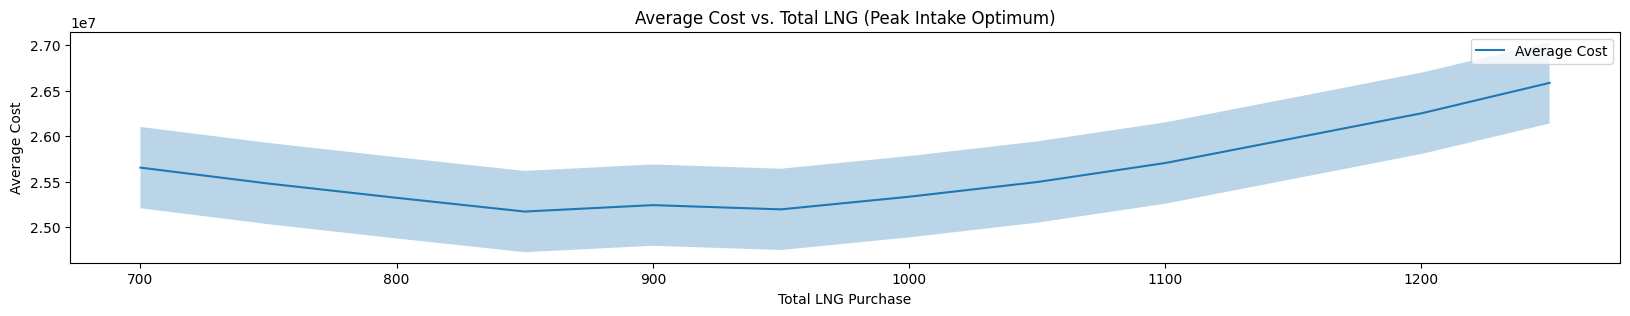

In [ ]:
optimum_peak_intake = 180

# Filter the DataFrame for this optimum value
df_peak_optimum = df[df['peak_intake_from_pipeline'] == optimum_peak_intake]

# Plotting
plt.figure()
plt.fill_between(df_peak_optimum['total_lng_purchase'], df_peak_optimum['total_utility_cost'] - df_peak_optimum['total_utility_cost'].std(),
                 df_peak_optimum['total_utility_cost'] + df_peak_optimum['total_utility_cost'].std(), alpha=0.3)
plt.plot(df_peak_optimum['total_lng_purchase'], df_peak_optimum['total_utility_cost'], label='Average Cost')
plt.xlabel('Total LNG Purchase')
plt.ylabel('Average Cost')
plt.title('Average Cost vs. Total LNG (Peak Intake Optimum)')
plt.legend()
plt.show()

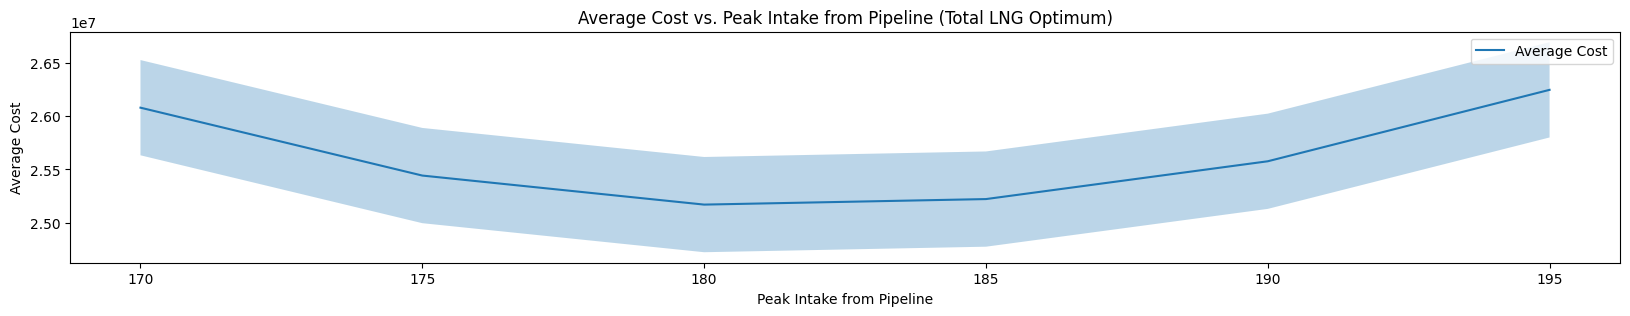

In [ ]:
# Identify the optimum value for total_lng_purchase
optimum_total_lng = 850

# Filter the DataFrame for this optimum value
df_lng_optimum = df[df['total_lng_purchase'] == optimum_total_lng]

# Plotting
plt.figure()
plt.fill_between(df_lng_optimum['peak_intake_from_pipeline'], df_lng_optimum['total_utility_cost'] - df_lng_optimum['total_utility_cost'].std(),
                 df_lng_optimum['total_utility_cost'] + df_lng_optimum['total_utility_cost'].std(), alpha=0.3)
plt.plot(df_lng_optimum['peak_intake_from_pipeline'], df_lng_optimum['total_utility_cost'], label='Average Cost')
plt.xlabel('Peak Intake from Pipeline')
plt.ylabel('Average Cost')
plt.title('Average Cost vs. Peak Intake from Pipeline (Total LNG Optimum)')
plt.legend()
plt.show()

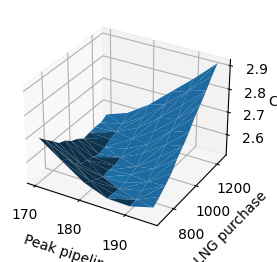

In [ ]:
from mpl_toolkits.mplot3d import Axes3D


def randrange(n, vmin, vmax):
    '''
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    '''
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
ax.plot_trisurf(df["peak_intake_from_pipeline"], df["total_lng_purchase"], df["total_utility_cost"])

ax.set_xlabel('Peak pipeline')
ax.set_ylabel('LNG purchase')
ax.set_zlabel('Cost')

plt.show()
